In [1]:
import yaml
import umap

import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import floor
from scipy.stats import mannwhitneyu

from carot.utils import get_source_target_transport, score_transports_and_targets_combinations
from cmonge.utils import load_config
from carot.trainers.conditional_monge_trainer import ConditionalMongeTrainer
from carot.datasets.conditional_loader import ConditionalDataModule

/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set(font="Arial")
sns.set_context("paper")
sns.set_style("whitegrid")
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ytick.left'] = True
mpl.rcParams['xtick.bottom'] = True

In [3]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "CAROT": default_colors["cyan"],
    "conCAROT": default_colors["indigo"],
    "conCAROT-OOD": default_colors["indigo"],
    "within condition": default_colors["green"],
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": default_colors["cyan"],
    "target": default_colors["sand"],
    "transport": default_colors["rose"],
    "rest": default_colors["grey"]
}


In [4]:
features = "/path/to/functional_and_score_genes.txt"

logger_path = "/path/to/experiments/cmonge_ood/sel_CARs_ood/"
base_config_path = "/path/to/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_ckpt_path = "/path/to/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_fig_save = "/path/to/Figures/cmonge/ood/sel_CARs_"

In [5]:
all_mean_metrics=[]
for subset in ["CD4", "CD8"]:
    for setting in ["identity", "cmonge", "within condition"]:
        with open(f"{logger_path}model_sel_cars_{subset}_{setting}_small_CARs_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["eval_car"] = condition
                res["eval_setting"] = setting
                res["subset"] = subset
                all_mean_metrics.append(res)

In [6]:
OOD_res = pd.concat(all_mean_metrics).reset_index(drop=True)
OOD_res = OOD_res[~OOD_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
OOD_res["eval_setting"] = ["conCAROT-OOD" if "cmonge" in s else s for s in OOD_res["eval_setting"]]

In [7]:
pvals = []
metrics = []
subsets = []
comparisons = []
for metric in ["mean_mmd", "mean_r2"]:
    for subset in ["CD8", "CD4"]:
        for comparison in [("conCAROT-OOD", "identity"), ("conCAROT-OOD", "within condition")]:
            sel_res = OOD_res[(OOD_res["metric"]==metric)&(OOD_res["subset"]==subset)]
           
            pval = mannwhitneyu(sel_res.loc[sel_res["eval_setting"]==comparison[0], "score"], 
                                sel_res.loc[sel_res["eval_setting"]==comparison[1], 'score'],
                               ).pvalue 
            pvals.append(pval)
            metrics.append(metric)
            subsets.append(subset)
            comparisons.append(comparison)
stats = pd.DataFrame({"pval": pvals, "subset": subsets, "metric": metrics})
stats[["setting1", "setting2"]] = comparisons
stats["corr_pval"] = stats["pval"] *len(stats)
stats["treshold"] = 0.05/len(stats)
stats["significant1"] =  stats["pval"] < stats["treshold"]
stats["significant2"] =  stats["corr_pval"] < 0.05
stats

,pval,subset,metric,setting1,setting2,corr_pval,treshold,significant1,significant2
0,5.700267e-02,CD8,mean_mmd,conCAROT-OOD,identity,4.560213e-01,0.00625,False,False
1,5.700267e-02,CD8,mean_mmd,conCAROT-OOD,within condition,4.560213e-01,0.00625,False,False
2,4.719793e-03,CD4,mean_mmd,conCAROT-OOD,identity,3.775835e-02,0.00625,True,True
3,2.951699e-01,CD4,mean_mmd,conCAROT-OOD,within condition,2.361359e+00,0.00625,False,False
4,1.544910e-06,CD8,mean_r2,conCAROT-OOD,identity,1.235928e-05,0.00625,True,True
5,2.492968e-02,CD8,mean_r2,conCAROT-OOD,within condition,1.994374e-01,0.00625,False,False
6,2.303303e-08,CD4,mean_r2,conCAROT-OOD,identity,1.842642e-07,0.00625,True,True
7,1.747734e-01,CD4,mean_r2,conCAROT-OOD,within condition,1.398187e+00,0.00625,False,False


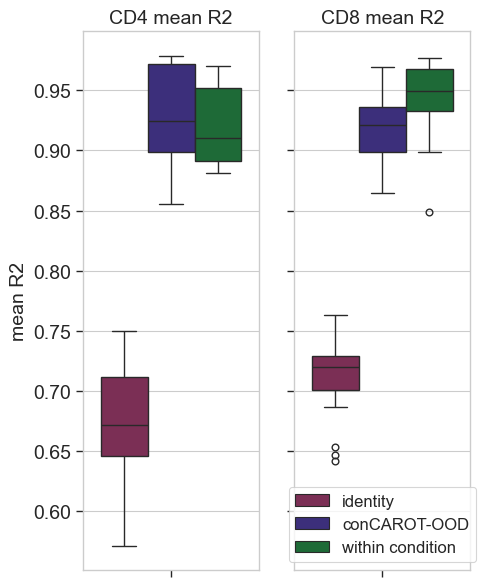

In [8]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = OOD_res[(OOD_res["subset"]==subset)&(OOD_res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "conCAROT-OOD", "within condition"])
    axes[i].set_title(f"{subset} mean R2", fontsize=14)
    axes[i].set_ylabel("mean R2", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_save}R2_performance.pdf", bbox_inches="tight")

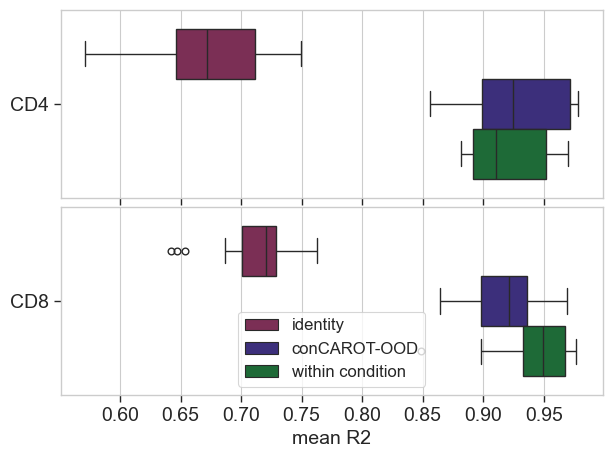

In [9]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = OOD_res[(OOD_res["subset"]==subset)&(OOD_res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, x="score", y="subset", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "conCAROT-OOD", "within condition"])
    axes[i].set_ylabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean R2", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_save}R2_performance_horizontal.pdf", bbox_inches="tight")

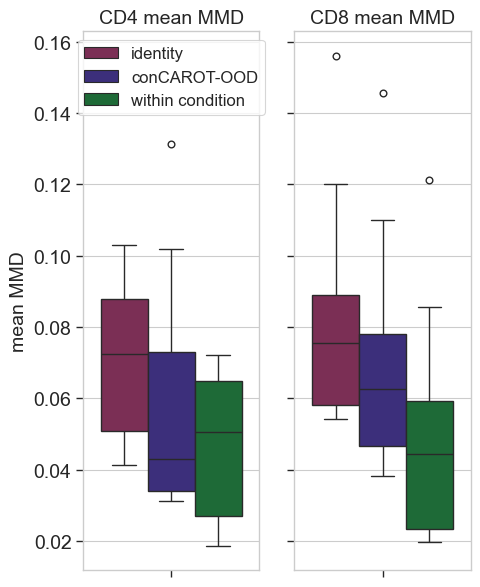

In [10]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = OOD_res[(OOD_res["subset"]==subset)&(OOD_res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "conCAROT-OOD", "within condition"])
    axes[i].set_title(f"{subset} mean MMD", fontsize=14)
    axes[i].set_ylabel("mean MMD", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[1].get_legend().remove()
axes[0].legend(fontsize=12, loc="upper center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_save}MMD_performance.pdf", bbox_inches="tight")

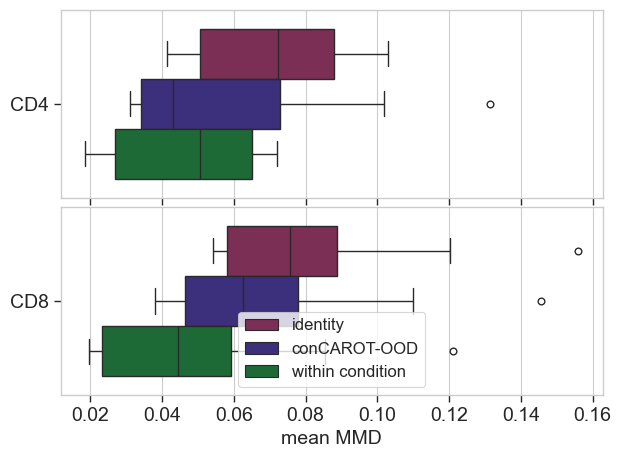

In [11]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = OOD_res[(OOD_res["subset"]==subset)&(OOD_res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, x="score", y="subset", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "conCAROT-OOD", "within condition"])
    axes[i].set_ylabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean MMD", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_save}MMD_performance_horizontal.pdf", bbox_inches="tight")

## Compare ID and OOD CARs in different evaluation settings

These next two cells take quite long. After these have been run the results are saved and loaded in the first uncommented block

### ConCAROT trained on CARs with >750 cells

In [12]:
# # setting="cmonge"
# setting="within condition"
# # setting="identity"

# for subset in ["CD4", "CD8"]:
#     adata = sc.read_h5ad(f'/path/to/data/{subset}.h5ad')
#     adata.X = adata.layers['logcounts']
#     with open(features, "r") as f:
#         genes = f.read().splitlines()
#     sel_adata = adata[:, genes]

#     config_path = f"{base_config_path}{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
#     config = load_config(config_path)
#     config.model.checkpointing_path = f"{base_ckpt_path}{subset}_esm_XL_tail_dim_FuncScore/model"
#     config.data.file_path = f"/path/to/data/{subset}.h5ad"
#     config.data.features = features
#     config.data.drugs_path = f"/path/to/{subset}_sel_cars.txt"
#     config.model.embedding.model_dir = "/path/to/embedding/"

#     print(config.model.checkpointing_path)

#     with open(config.data.drugs_path) as f:
#         train_cars = f.readlines()
#     train_cars = [c[:-1] for c in train_cars]

#     for car in sel_adata.obs["CAR_Variant"].unique():
#         if car in ["NA-NA-NA", "NA-NA-z"]:
#             continue
#         if car in train_cars: # HERE ADD/REMOVE A "NOT" TO SWITCH BETWEEN >750 AND <750 CELLS CARS
#             continue
#         config.condition.split = [0,1,0]
#         config.data.split = [0,1,0]
#         batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
#         batch_size = floor(batch_size * config.data.split[1] / 9) # 9 in n_samples of the evaluation modules

#         config.data.batch_size=batch_size
#         config.condition.conditions = [car]

#         if setting=="within condition":
#             config.data.control_condition=car
        
#         datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
#         trainer = ConditionalMongeTrainer.load_checkpoint(
#             jobid=1,
#             logger_path=f"{logger_path}model_sel_cars_{subset}_{setting}_small_cars_eval.yaml", # HERE CHANGE BETWEEN "SMALL" AND "LARGE"
#             config=config.model, 
#             datamodule=datamodule, 
#             ckpt_path=config.model.checkpointing_path
#             )

#         if setting=="identity" or setting=="within condition":
#             trainer.evaluate(datamodule, identity=True)
#         else:
#             trainer.evaluate(datamodule)


### conCAROT trained on all CARs

In [13]:
# setting="cmonge"

# for subset in ["CD4", "CD8"]:

#     config_path = f"/path/to/experiments/cmonge/LN_True_grad_acc_4_cosine/{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
#     config = load_config(config_path)
#     config.model.checkpointing_path = f"/path/to/experiments/cmonge/LN_True_grad_acc_4_cosine/{subset}_esm_XL_tail_dim_FuncScore/model"
#     config.data.file_path = f"/path/to/data/{subset}.h5ad"
#     config.data.features = features
#     config.data.drugs_path = f"/path/to/{subset}_sel_cars.txt"
#     config.model.embedding.model_dir = "/path/to/embedding/"

#     with open(config.data.drugs_path) as f:
#         train_cars = f.readlines()
#     train_cars = [c[:-1] for c in train_cars]

#     for car in sel_adata.obs["CAR_Variant"].unique():
#         if car in ["NA-NA-NA", "NA-NA-z"]:
#             continue
#         if car in train_cars: # HERE ADD/REMOVE A "NOT" TO SWITCH BETWEEN >750 AND <750 CELLS CARS
#             continue
#         config.condition.split = [0,1,0]
#         config.data.split = [0,1,0]
#         batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
#         batch_size = floor(batch_size * config.data.split[1] / 9) # 9 in n_samples of the evaluation modules

#         config.data.batch_size=batch_size
#         config.condition.conditions = [car]

#         if setting=="within condition":
#             config.data.control_condition=car
        
#         datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
#         trainer = ConditionalMongeTrainer.load_checkpoint(
#             jobid=1,
#             logger_path=f"{logger_path}model_all_cars_{subset}_{setting}_small_CARs_eval.yaml", # HERE CHANGE BETWEEN "SMALL" AND "LARGE"
#             config=config.model, 
#             datamodule=datamodule, 
#             ckpt_path=config.model.checkpointing_path
#             )

#         if setting=="identity" or setting=="within condition":
#             trainer.evaluate(datamodule, identity=True)
#         else:
#             trainer.evaluate(datamodule)


In [14]:
all_mean_metrics=[]
for subset in ["CD4", "CD8"]:
    for setting in ["cmonge"]:
        with open(f"{logger_path}model_sel_cars_{subset}_{setting}_sel_CARs_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["eval_car"] = condition
                res["eval_setting"] = setting
                res["subset"] = subset
                res["OOD_ID"] = ">750 cells"
                res["model"] = "sel_cars"
                all_mean_metrics.append(res)

        with open(f"{logger_path}model_all_cars_{subset}_{setting}_sel_CARs_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["eval_car"] = condition
                res["eval_setting"] = setting
                res["subset"] = subset
                res["OOD_ID"] = ">750 cells"
                res["model"] = "all_cars"
                all_mean_metrics.append(res)

        with open(f"{logger_path}model_all_cars_{subset}_{setting}_small_CARs_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["eval_car"] = condition
                res["eval_setting"] = setting
                res["subset"] = subset
                res["OOD_ID"] = "<750 cells"
                res["model"] = "all_cars"
                all_mean_metrics.append(res)

In [15]:
ID_res = pd.concat(all_mean_metrics).reset_index(drop=True)
ID_res = ID_res[~ID_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
ID_res["eval_setting"] = ["conCAROT" if "cmonge" in s else s for s in ID_res["eval_setting"]]

In [16]:
ID_res["eval_setting"].unique()

array(['conCAROT'], dtype=object)

In [17]:
temp = OOD_res[(OOD_res["eval_setting"]=="conCAROT-OOD")]
temp["OOD_ID"] = "<750 cells"
temp["model"] = "sel_cars"
all_res = pd.concat([ID_res, temp])
ID_OOD_map = {"<750 cells": default_colors["rose"], ">750 cells": default_colors["green"]}

/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_33271/1281460159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["OOD_ID"] = "<750 cells"
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_33271/1281460159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["model"] = "sel_cars"


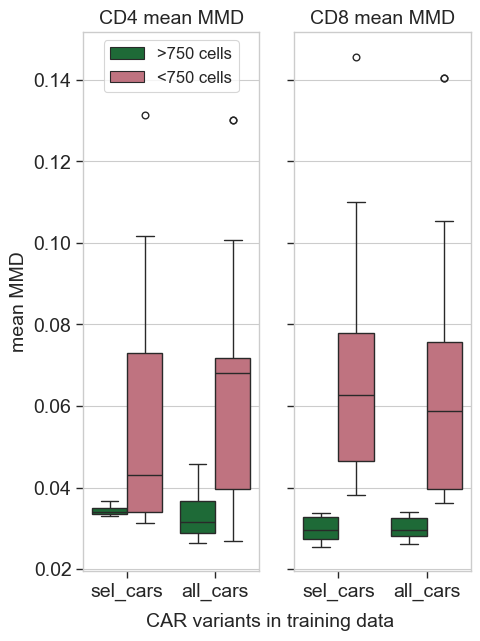

In [18]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = all_res[(all_res["subset"]==subset)&(all_res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", ax=axes[i], hue="OOD_ID", x="model", palette=ID_OOD_map)
    axes[i].set_title(f"{subset} mean MMD", fontsize=14)
    axes[i].set_ylabel("mean MMD", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[1].get_legend().remove()
axes[0].legend(fontsize=12, loc="upper center")
fig.text(0.25, 0.03, "CAR variants in training data", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_save}MMD_all_sel_CARs_OOD_ID_performance.pdf", bbox_inches="tight")

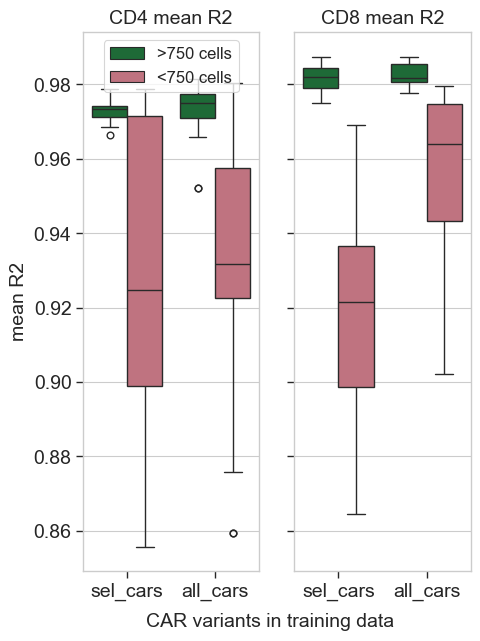

In [19]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = all_res[(all_res["subset"]==subset)&(all_res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", ax=axes[i], hue="OOD_ID", x="model", palette=ID_OOD_map)
    axes[i].set_title(f"{subset} mean R2", fontsize=14)
    axes[i].set_ylabel("mean R2", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[1].get_legend().remove()
axes[0].legend(fontsize=12, loc="upper center")
fig.text(0.25, 0.03, "CAR variants in training data", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_save}R2_all_sel_CARs_OOD_ID_performance.pdf", bbox_inches="tight")

In [20]:
all_res["eval_setting"].unique()

array(['conCAROT', 'conCAROT-OOD'], dtype=object)

In [21]:
all_res.loc[(all_res["model"]=="sel_cars")&(all_res["subset"]=="CD4")&(all_res["metric"]=="mean_r2")]


,metric,score,eval_car,eval_setting,subset,OOD_ID,model
5,mean_r2,0.973764,41BB-41BB-z,conCAROT,CD4,>750 cells,sel_cars
11,mean_r2,0.978709,41BB-CD28-z,conCAROT,CD4,>750 cells,sel_cars
17,mean_r2,0.972268,41BB-CD40-z,conCAROT,CD4,>750 cells,sel_cars
23,mean_r2,0.966480,41BB-IL15RA-z,conCAROT,CD4,>750 cells,sel_cars
29,mean_r2,0.973108,41BB-NA-z,conCAROT,CD4,>750 cells,sel_cars
35,mean_r2,0.973801,CD28-CD28-z,conCAROT,CD4,>750 cells,sel_cars
41,mean_r2,0.971818,CD28-CD40-z,conCAROT,CD4,>750 cells,sel_cars
47,mean_r2,0.974233,CD28-IL15RA-z,conCAROT,CD4,>750 cells,sel_cars
53,mean_r2,0.971564,CD28-NA-z,conCAROT,CD4,>750 cells,sel_cars
59,mean_r2,0.969895,CD40-IL15RA-z,conCAROT,CD4,>750 cells,sel_cars


In [22]:
all_res.loc[(all_res["model"]=="all_cars")&(all_res["subset"]=="CD4")&(all_res["metric"]=="mean_r2")]


,metric,score,eval_car,eval_setting,subset,OOD_ID,model
101,mean_r2,0.974931,41BB-41BB-z,conCAROT,CD4,>750 cells,all_cars
107,mean_r2,0.971670,41BB-CD28-z,conCAROT,CD4,>750 cells,all_cars
113,mean_r2,0.952090,41BB-CD40-z,conCAROT,CD4,>750 cells,all_cars
119,mean_r2,0.974842,41BB-IL15RA-z,conCAROT,CD4,>750 cells,all_cars
125,mean_r2,0.978993,41BB-NA-z,conCAROT,CD4,>750 cells,all_cars
131,mean_r2,0.976041,CD28-CD28-z,conCAROT,CD4,>750 cells,all_cars
137,mean_r2,0.969021,CD28-CD40-z,conCAROT,CD4,>750 cells,all_cars
143,mean_r2,0.977967,CD28-IL15RA-z,conCAROT,CD4,>750 cells,all_cars
149,mean_r2,0.976385,CD28-NA-z,conCAROT,CD4,>750 cells,all_cars
155,mean_r2,0.965966,CD40-IL15RA-z,conCAROT,CD4,>750 cells,all_cars
